In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from lightgbm import LGBMClassifier
import utils

In [88]:
df_test = pd.read_csv("test-full.csv")
df_train = pd.read_csv("train.csv")
# pour avoir cover type au début
df_train = df_train[[df_train.columns[-1]] + list(df_train.columns[0:-1])]

In [89]:
df_train.shape, df_test.shape

((15120, 56), (581012, 55))

In [90]:
df_test.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,0
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,0
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,0
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,0
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,0


In [91]:
df_train["Cover_Type"].value_counts()

1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
Name: Cover_Type, dtype: int64

### Basis script

In [92]:
from sklearn.ensemble import RandomForestClassifier

# Separate features and target 
X_train = df_train.drop('Cover_Type', axis=1)
y_train = df_train['Cover_Type']

# Initialize and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Creating a Test dataset
X_test = df_test

# Make predictions on the test dataset
y_pred = clf.predict(X_test)

# Saving predictions to a CSV file
predictions_df = pd.DataFrame({'Cover_Type': y_pred})

# Having it fit the desired format
Id = [i for i in range (1, 581013)]
predictions_df['Id'] = Id
# predictions_df.to_csv('test_predictions.csv', index=False) # peut-être plus simple de directement mettre index = True


In [93]:
predictions_df["Cover_Type"].value_counts()

2    236112
1    216326
3     38178
7     31667
5     28425
6     26278
4      4026
Name: Cover_Type, dtype: int64

### First train-test

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Si on met que la df en input
def classif(df_train=df_train, clf=RandomForestClassifier(n_estimators=150, random_state=42)):
    
    if "Wilderness_Area_Synth" in df_train.columns:
        df_train = df_train.drop(columns="Wilderness_Area_Synth")

    # Separate features and target 
    X_train = df_train.drop('Cover_Type', axis=1)
    y_train = df_train['Cover_Type']

    data_train, data_test, target_train, target_test = train_test_split(
        X_train, y_train, test_size = 0.2
    )

    # Initialize and train a Random Forest classifier
    clf.fit(data_train, target_train)

    # Make predictions on the test dataset
    y_pred = clf.predict(data_test)
    
    return target_test, y_pred

# Si test & train déjà définis
def RF_classif_train_test(data_train, target_train, data_test, target_test):

    # Initialize and train a Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(data_train, target_train)

    # Make predictions on the test dataset
    y_pred = clf.predict(data_test)
    
    return target_test, y_pred

In [9]:
y_true, y_pred = classif()
accuracy_score(y_true, y_pred) # bien meilleur score que sur Kags

0.8882275132275133

In [10]:
print(classification_report(y_true, y_pred))

# On prédit moins bien 1 et 2, ce qui est un problème pcq représentent une immense majorité du dataset final

              precision    recall  f1-score   support

           1       0.83      0.83      0.83       415
           2       0.84      0.72      0.77       416
           3       0.89      0.87      0.88       441
           4       0.94      0.98      0.96       429
           5       0.91      0.95      0.93       464
           6       0.85      0.87      0.86       416
           7       0.95      0.98      0.97       443

    accuracy                           0.89      3024
   macro avg       0.89      0.89      0.88      3024
weighted avg       0.89      0.89      0.89      3024



# Over/undersampling

In [11]:
# on peut essayer d'undersampler wilderness area 4 
# pcq à ce stade il semblerait que a été tiré uniformément dans les wilderness areas

# ou alors oversampler tous les autres pour aboutir à des proportions similaires à celles d'origine

# Ou alors oversampler directement des classes (ex 1 et 2 mais peut être problématique)

### Working directly on the Cover Type

In [12]:
from imblearn.over_sampling import ADASYN
predictions_df["Cover_Type"].value_counts() / len(predictions_df)

2    0.406381
1    0.372326
3    0.065709
7    0.054503
5    0.048923
6    0.045228
4    0.006929
Name: Cover_Type, dtype: float64

In [13]:
df_train["Cover_Type"].value_counts() / len(df_train)

1    0.142857
2    0.142857
3    0.142857
4    0.142857
5    0.142857
6    0.142857
7    0.142857
Name: Cover_Type, dtype: float64

In [14]:
### OVERSAMPLING CLASS 2 AND 1

ovs_strat = {1: 15_000, 2: 15_000}

# Separating train and test
X = df_train.drop('Cover_Type', axis=1)
y = df_train['Cover_Type']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

# Define the over-sampler
adasyn = ADASYN(sampling_strategy=ovs_strat)

# Oversampling
X_train_synth, y_train_synth = adasyn.fit_resample(X_train, y_train)
X_train_synth = pd.DataFrame(X_train_synth, columns=X_train.columns)

In [15]:
y_train_synth.value_counts() / len(y_train_synth)

2    0.391288
1    0.386949
5    0.044699
3    0.044415
7    0.044311
6    0.044182
4    0.044156
Name: Cover_Type, dtype: float64

In [16]:
y_true, y_pred = RF_classif_train_test(X_train_synth, y_train_synth, X_test, y_test)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.77      0.81      0.79       408
           2       0.72      0.76      0.74       404
           3       0.89      0.81      0.85       440
           4       0.94      0.99      0.96       450
           5       0.94      0.88      0.91       429
           6       0.86      0.88      0.87       449
           7       0.97      0.94      0.96       444

    accuracy                           0.87      3024
   macro avg       0.87      0.87      0.87      3024
weighted avg       0.87      0.87      0.87      3024



In [17]:
# Par rapport à avant, améliore le recall (moins de faux négatifs) mais diminue la précision (plus de faux positifs)

y_true, y_pred = classif(df_train)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.81      0.81      0.81       464
           2       0.79      0.75      0.77       421
           3       0.89      0.83      0.86       425
           4       0.93      0.98      0.96       430
           5       0.90      0.95      0.93       399
           6       0.88      0.89      0.89       424
           7       0.96      0.97      0.96       461

    accuracy                           0.88      3024
   macro avg       0.88      0.88      0.88      3024
weighted avg       0.88      0.88      0.88      3024



### Trying

In [18]:
### TEST
from utils import clean_predictor

# Initialize and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=150)
clf.fit(X_train_synth, y_train_synth)

# Make predictions on the test dataset
y_pred = clf.predict(df_test)

# Saving predictions to a CSV file
predictions_df = clean_predictor(y_pred)

# Having it fit the desired format
predictions_df.to_csv('test_predictions.csv', index=False) # peut-être plus simple de directement mettre index = True

Exception in thread Thread-6 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\User\anaconda3\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\User\anaconda3\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\User\anaconda3\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 16: invalid start byte
c:\Users\User\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\User\anaconda3\Lib\site-packages\joblib\externals\loky\

In [19]:
## on atteint 0.82 => Amélioration légère

# Essayer de le faire de manière plus méthodique, en augmentant encore plus et notamment le WA1,
# et en tunant : on dirait que en fonction du fit du ADASYN on a des résultats assez différents

In [20]:
predictions_df["Cover_Type"].value_counts()

2    253208
1    218537
3     35807
7     26433
6     23675
5     19219
4      4133
Name: Cover_Type, dtype: int64

In [21]:
# On remarque que on a sensiblement plus de classe 2 prédite ici que à la base

## kmeans + oversampling

In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from utils import clean_predictor


### 1. OVERSAMPLING CLASS 2 AND 1
ovs_strat = {1: 30_000, 2: 30_000}

# Separating train 
X_train = df_train.drop(columns=['Cover_Type'], axis=1)
y_train = df_train['Cover_Type']

# Oversampling
adasyn = ADASYN(sampling_strategy=ovs_strat)
X_train_synth, y_train_synth = adasyn.fit_resample(X_train, y_train)
X_train_synth = pd.DataFrame(X_train_synth, columns=X_train.columns)

### 2. KMEANS
df_train_ns = df_train.iloc[:,:16]
df_test_ns = df_test.iloc[:,:15]

km_test = KMeans(n_clusters=3, n_init=10, init="k-means++")
km_test.fit_predict(df_test_ns)
df_test["kmean_cluster"] = km_test.labels_
X_train_synth["kmean_cluster"] = km_test.predict(X_train_synth.iloc[:,:15])

### 3. GENERATING
cat_col = ["kmean_cluster"]
cols = X_train_synth.drop(columns=['kmean_cluster']).columns

preprocessor = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_col),
        ("others", "passthrough", cols),
    ])
clf = RandomForestClassifier(n_estimators=150)
pipe = make_pipeline(preprocessor, clf)

pipe.fit(X_train_synth, y_train_synth)
y_pred = pipe.predict(df_test)
predictions_df = clean_predictor(y_pred)

# Having it fit the desired format
# predictions_df.to_csv('test_predictions.csv', index=False) 

# Building a solid cross validation metric

Idée : appliquer la "importance weighted cross validation" du paper.

$$\hat{R}^{(n)}_{kIWCV} = \frac{1}{k}\sum_{j=1}^{k} \frac{1}{|T_j|} \sum_{(x_i, y_i) \in T_j} \frac{p_{test}(x_i)}{p_{train}(x_i)} \ell(x_i, y_i, \hat{y_i})$$

Question : comment estimer $\frac{p_{test}(x_i)}{p_{train}(x_i)}$ pour tout $x_i$ du train set?


Question : est-ce que a samplé de manière uniforme sur les classes ? Si oui, on peut juste reweighter sur les proportions des classes. Comment on peut savoir ? On peut nous aussi ressampler au hasard pour avoir des classes uniformes et voir si semble correspondre. 

Note ici notre loss est la l1 loss = 1 - accuracy donc on peut échanger la loss avec l'accuracy

In [24]:
### Trying to get the same data the train from the test
class_size = 2160
df_copy = pd.DataFrame()

for label in range(1,8):
    class_data = df_train[df_train['Cover_Type'] == label]
    sampled_data = class_data.sample(n=class_size, replace=False, random_state=1000)
    df_copy = pd.concat([df_copy, sampled_data])

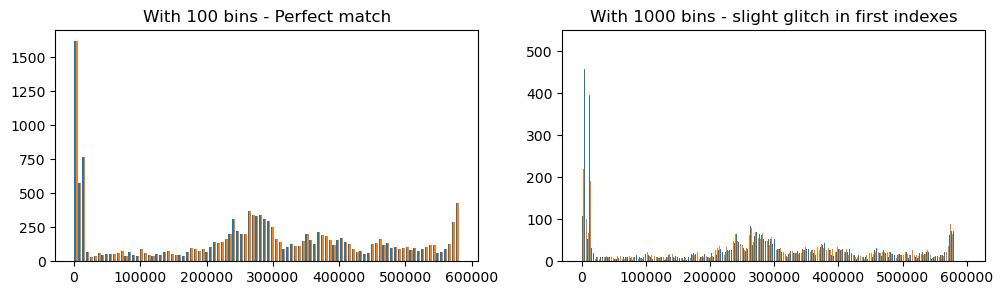

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].hist([df_train["Id"], df_copy["Id"]], bins=100)
axs[0].set_title(f'With 100 bins - Perfect match')
axs[1].hist([df_train["Id"], df_copy["Id"]], bins=range(0, 600_000, 1000))
axs[1].set_title(f'With 1000 bins - slight glitch in first indexes')
plt.show()

Correspond globalement.

On peut donc faire $\frac{p_{test}(x_i)}{p_{train}(x_i)} = \frac{p_{train}(y_i|x_i) p_{test}(y_i) p_{test}(x_i|y_i)}{p_{test}(y_i|x_i) p_{train}(y_i) p_{train}(x_i|y_i)}$

Puis on annule $\frac{p_{train}(y_i|x_i)}{p_{test}(y_i|x_i)}$ par assumption (label shift) et $\frac{p_{train}(x_i|y_i)}{p_{test}(x_i|y_i)}$ par ce qu'on vient de voir (au sein d'une classe donnée, les X ont la même distribution)

Il reste $\frac{p_{test}(x_i)}{p_{train}(x_i)} = \frac{p_{test}(y_i)}{p_{train}(y_i)}$, que l'on peut estimer directement avec les proportions de chaque classe dans le train et indirectement avec les proportions prédites dans le train (c'est une approximation mais ça fera l'affaire

In [26]:
coeffs = (predictions_df["Cover_Type"].value_counts() / len(predictions_df) / df_train["Cover_Type"].value_counts() * len(df_train)).round(2)
coeffs = np.array([2.63, 3.06, 0.43, 0.05, 0.24, 0.27, 0.32])

In [27]:
def IWCV(df_train=df_train, 
         predictor=RandomForestClassifier(n_estimators=100, random_state=42), 
         k_valid=10,
         coeffs=coeffs):
    
    if "Wilderness_Area_Synth" in df_train.columns:
        df_train = df_train.drop(columns="Wilderness_Area_Synth")
        
    # Separate features and target 
    X_train = df_train.drop('Cover_Type', axis=1)
    y_train = df_train['Cover_Type']
    
    class_accuracies = np.zeros((k_valid, 7))
    
    for i in range(k_valid):
        data_train, data_test, target_train, target_test = train_test_split(
            X_train, y_train, test_size = 1 / k_valid
        )
        predictor.fit(data_train, target_train)
        y_pred = predictor.predict(data_test)

        for label in range(1,8):
            class_accuracies[i, label - 1] = accuracy_score(target_test[target_test == label], 
                                                        y_pred[target_test == label])
        IMCV = np.mean(class_accuracies @ coeffs) / np.sum(coeffs)
        
    return IMCV, class_accuracies.mean(axis=0)

In [28]:
IWCV()

(0.7910823889207997,
 array([0.80953825, 0.72115609, 0.85978142, 0.98255647, 0.95580071,
        0.88924534, 0.97947262]))

### Combining IWCV and oversampler

In [85]:
def IWCV_oversample(df_train=df_train, 
         predictor=RandomForestClassifier(n_estimators=100, random_state=42), 
         k_valid=10,
         coeffs=coeffs,
         verbose=False) :
    
    ovs_strat = {1: 30_000, 2: 30_000}
    if "Wilderness_Area_Synth" in df_train.columns:
        df_train = df_train.drop(columns="Wilderness_Area_Synth")

    # Define the oversampler
    adasyn = ADASYN(sampling_strategy=ovs_strat) ## Random state = 4 ou 1 sont les meilleurs so far à 0.8297 en CV (mais fixer seed aussi en cross_val...)

    # Separate features and target 
    X_train = df_train.drop('Cover_Type', axis=1)
    y_train = df_train['Cover_Type']
    
    class_accuracies = np.zeros((k_valid, 7))
    
    for i in range(k_valid):
        if verbose:
            print(f"Current fold: {i}")
        data_train, data_test, target_train, target_test = train_test_split(
            X_train, y_train, test_size = 1 / k_valid
        )
        
        # Oversampling
        X_train_synth, y_train_synth = adasyn.fit_resample(data_train, target_train)
        X_train_synth = pd.DataFrame(X_train_synth, columns=X_train.columns)
        
        predictor.fit(X_train_synth, y_train_synth)
        y_pred = predictor.predict(data_test)

        for label in range(1,8):
            class_accuracies[i, label - 1] = accuracy_score(target_test[target_test == label], 
                                                        y_pred[target_test == label])
        IMCV = np.mean(class_accuracies @ coeffs) / np.sum(coeffs)
        
    return IMCV, class_accuracies.mean(axis=0)

### Oversampling + kmeans

In [31]:
### Setting pipe
from sklearn.preprocessing import FunctionTransformer

def pipe_setter(n_clusters=3, clf=RandomForestClassifier(n_estimators=100, random_state=42)):
    # Initializing kmeans
    km_test = KMeans(n_clusters=n_clusters, n_init=10, init="k-means++")
    km_test.fit_predict(df_test.loc[:, "Id":"Wilderness_Area4"])

    # Setting pipe
    def _enocode_kmeans(X, kmeans=km_test):
        X = X.copy()
        X["kmean_cluster"] = kmeans.predict(X)
        return X
    km_encoder = FunctionTransformer(_enocode_kmeans)

    cat_col = ["kmean_cluster"]
    cols = df_train.drop(columns=['Cover_Type', 'Wilderness_Area_Synth']).columns

    preprocessor = ColumnTransformer([
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_col),
            ("others", "passthrough", cols),
        ])
    
    return make_pipeline(km_encoder, preprocessor, clf)

In [32]:
def IWCV_ovs_km(df_train=df_train, 
         predictor=pipe_setter(), 
         k_valid=10,
         coeffs=coeffs,
         ovs_strat={1: 30_000, 2: 30_000}):
    
    if "Wilderness_Area_Synth" in df_train.columns:
        df_train = df_train.drop(columns="Wilderness_Area_Synth")

    # Define the oversampler
    adasyn = ADASYN(sampling_strategy=ovs_strat) 

    # Separate features and target 
    X_train = df_train.drop('Cover_Type', axis=1)
    y_train = df_train['Cover_Type']
    
    class_accuracies = np.zeros((k_valid, 7))
    
    for i in range(k_valid):
        data_train, data_test, target_train, target_test = train_test_split(
            X_train, y_train, test_size = 1 / k_valid
        )
        
        # Oversampling
        X_train_synth, y_train_synth = adasyn.fit_resample(data_train, target_train)
        X_train_synth = pd.DataFrame(X_train_synth, columns=X_train.columns)
        
        predictor.fit(X_train_synth, y_train_synth)
        y_pred = predictor.predict(data_test)

        for label in range(1,8):
            class_accuracies[i, label - 1] = accuracy_score(target_test[target_test == label], 
                                                        y_pred[target_test == label])
        IMCV = np.mean(class_accuracies @ coeffs) / np.sum(coeffs)
        
    return IMCV, class_accuracies.mean(axis=0)

In [33]:
### très bizarre parce que varie énormément => excellents résultats ou bofs alors que mêmes paramètres
# Faire un truc long en 20 - cross val et 3 fois par clusters sur des clusters allant de 3 à 7
### So far on dirait que n_clusters = 7 donne le meilleur résultat mais tuner à la fin

In [34]:
# dico_km =  
# 3 (0.8345399423561863, array([0.84882253, 0.79977842, 0.85926981, 0.9786671 , 0.88242925,
#        0.86635208, 0.9336357 ]))
# 4 (0.8382094548710572, array([0.85103149, 0.8038529 , 0.87349019, 0.97339922, 0.88498326,
#        0.86922649, 0.93411541]))
# 5 (0.8259548777699849, array([0.83459958, 0.79100115, 0.86031783, 0.98022758, 0.87694589,
#        0.87492816, 0.94199221]))
# 6 (0.8256605234316455, array([0.83774458, 0.7857139 , 0.87296434, 0.97455323, 0.89697963,
#        0.85820505, 0.94403361]))
# 7 (0.8406299332597281, array([0.85340261, 0.8082526 , 0.8536078 , 0.97417891, 0.88834775,
#        0.87670995, 0.94322887]))
# 8 (0.8343907127838309, array([0.8422739 , 0.80129691, 0.867198  , 0.98046184, 0.89575921,
#        0.86753523, 0.9481118 ]))

In [ ]:
IWCV_ovs_km()

# Stacking

Quels algos utiliser?

In [35]:
from sklearn.calibration import LabelEncoder
from xgboost import XGBClassifier

data_train, data_test, target_train, target_test = train_test_split(
    X_train, y_train, test_size = 0.2
)

le = LabelEncoder()
target_train = le.fit_transform(target_train)
model = XGBClassifier()
model.fit(data_train, target_train)
y_pred = model.predict(data_test)
y_pred = le.inverse_transform(y_pred)

print(classification_report(target_test, y_pred)) # Globalement pareil que le RF

              precision    recall  f1-score   support

           1       0.82      0.80      0.81       451
           2       0.81      0.73      0.77       449
           3       0.90      0.88      0.89       420
           4       0.96      0.98      0.97       464
           5       0.89      0.96      0.93       416
           6       0.88      0.91      0.89       407
           7       0.96      0.98      0.97       417

    accuracy                           0.89      3024
   macro avg       0.89      0.89      0.89      3024
weighted avg       0.89      0.89      0.89      3024



In [36]:
from sklearn.ensemble import AdaBoostClassifier
y_true, y_pred = classif(clf=AdaBoostClassifier(algorithm='SAMME'))

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.46      0.73      0.57       424
           2       0.25      0.12      0.17       408
           3       0.58      0.37      0.45       446
           4       0.51      0.93      0.66       428
           5       0.62      0.58      0.60       452
           6       0.54      0.35      0.42       439
           7       0.80      0.73      0.76       427

    accuracy                           0.54      3024
   macro avg       0.54      0.54      0.52      3024
weighted avg       0.54      0.54      0.52      3024



In [37]:
from sklearn.ensemble import GradientBoostingClassifier

y_true, y_pred = classif(clf=GradientBoostingClassifier())

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.77      0.73      0.75       451
           2       0.73      0.63      0.68       434
           3       0.78      0.81      0.80       415
           4       0.94      0.95      0.94       443
           5       0.82      0.89      0.85       414
           6       0.80      0.78      0.79       418
           7       0.88      0.96      0.92       449

    accuracy                           0.82      3024
   macro avg       0.82      0.82      0.82      3024
weighted avg       0.82      0.82      0.82      3024



In [38]:
from sklearn.tree import DecisionTreeClassifier

y_true, y_pred = classif(clf=DecisionTreeClassifier())

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.71      0.68      0.70       454
           2       0.67      0.67      0.67       454
           3       0.84      0.79      0.81       448
           4       0.93      0.95      0.94       437
           5       0.86      0.88      0.87       401
           6       0.78      0.81      0.80       405
           7       0.91      0.94      0.92       425

    accuracy                           0.81      3024
   macro avg       0.81      0.82      0.81      3024
weighted avg       0.81      0.81      0.81      3024



In [39]:
from sklearn.svm import SVC

y_true, y_pred = classif(clf=SVC(kernel='rbf'))

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.57      0.01      0.02       436
           2       0.51      0.41      0.46       426
           3       0.30      0.42      0.35       426
           4       0.54      0.77      0.63       422
           5       0.00      0.00      0.00       431
           6       0.28      0.41      0.34       438
           7       0.37      0.70      0.49       445

    accuracy                           0.39      3024
   macro avg       0.37      0.39      0.33      3024
weighted avg       0.37      0.39      0.32      3024



c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [80]:
from sklearn.neighbors import KNeighborsClassifier

y_true, y_pred = classif(clf=KNeighborsClassifier(1))
print(classification_report(y_true, y_pred))

y_true, y_pred = classif(clf=KNeighborsClassifier(5))
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.76      0.67      0.71       409
           2       0.74      0.67      0.70       466
           3       0.74      0.72      0.73       431
           4       0.86      0.92      0.89       431
           5       0.85      0.88      0.86       442
           6       0.74      0.80      0.77       410
           7       0.89      0.94      0.91       435

    accuracy                           0.80      3024
   macro avg       0.80      0.80      0.80      3024
weighted avg       0.80      0.80      0.80      3024

              precision    recall  f1-score   support

           1       0.66      0.60      0.63       407
           2       0.67      0.55      0.61       431
           3       0.69      0.68      0.68       462
           4       0.88      0.90      0.89       440
           5       0.80      0.87      0.83       433
           6       0.70      0.74      0.72       432
           7       0.85 

In [41]:
from sklearn.neural_network import MLPClassifier

y_true, y_pred = classif(clf=MLPClassifier())
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.29      0.08      0.12       439
           2       0.80      0.02      0.04       434
           3       0.38      0.01      0.02       450
           4       0.91      0.63      0.75       407
           5       0.57      0.18      0.27       395
           6       0.35      0.66      0.46       464
           7       0.26      0.97      0.41       435

    accuracy                           0.36      3024
   macro avg       0.51      0.36      0.30      3024
weighted avg       0.50      0.36      0.29      3024



In [42]:
from sklearn.naive_bayes import GaussianNB

y_true, y_pred = classif(clf=GaussianNB())
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.55      0.56      0.55       428
           2       0.48      0.37      0.42       469
           3       0.61      0.47      0.53       452
           4       0.80      0.87      0.83       406
           5       0.64      0.70      0.67       454
           6       0.52      0.60      0.56       407
           7       0.75      0.83      0.79       408

    accuracy                           0.62      3024
   macro avg       0.62      0.63      0.62      3024
weighted avg       0.62      0.62      0.62      3024



In [55]:
from sklearn.ensemble import ExtraTreesClassifier

y_true, y_pred = classif(clf=ExtraTreesClassifier())
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.81      0.83      0.82       417
           2       0.84      0.75      0.79       469
           3       0.87      0.88      0.88       416
           4       0.93      0.98      0.96       425
           5       0.91      0.93      0.92       437
           6       0.87      0.87      0.87       408
           7       0.95      0.98      0.97       452

    accuracy                           0.89      3024
   macro avg       0.88      0.89      0.89      3024
weighted avg       0.89      0.89      0.89      3024



In [52]:
from lightgbm import LGBMClassifier

y_true, y_pred = classif(clf=LGBMClassifier())
print(classification_report(y_true, y_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2418
[LightGBM] [Info] Number of data points in the train set: 12096, number of used features: 45
[LightGBM] [Info] Start training from score -1.961071
[LightGBM] [Info] Start training from score -1.943021
[LightGBM] [Info] Start training from score -1.941867
[LightGBM] [Info] Start training from score -1.940715
[LightGBM] [Info] Start training from score -1.945332
[LightGBM] [Info] Start training from score -1.952296
[LightGBM] [Info] Start training from score -1.937267
              precision    recall  f1-score   support

           1       0.82      0.79      0.81       458
           2       0.82      0.71      0.76       427
           3       0.89      0.88      0.88       425
           4       0.95      0.97      0.96       423
           5       0.91      0.96      0.94       431
        

In [83]:
IWCV(predictor=LGBMClassifier())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2419
[LightGBM] [Info] Number of data points in the train set: 13608, number of used features: 45
[LightGBM] [Info] Start training from score -1.946939
[LightGBM] [Info] Start training from score -1.939245
[LightGBM] [Info] Start training from score -1.945396
[LightGBM] [Info] Start training from score -1.950034
[LightGBM] [Info] Start training from score -1.946939
[LightGBM] [Info] Start training from score -1.940779
[LightGBM] [Info] Start training from score -1.952102
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2415
[LightGBM] [Info] Number of data points in the train set: 13608, number of used features: 45
[LightGBM] [Info] Start training from score 

(0.8051053933747129,
 array([0.81217726, 0.7444687 , 0.88809278, 0.97956911, 0.96056728,
        0.91257205, 0.98077622]))

In [86]:
IWCV_oversample(predictor=LGBMClassifier(), verbose=True)

Current fold: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2456
[LightGBM] [Info] Number of data points in the train set: 69823, number of used features: 48
[LightGBM] [Info] Start training from score -0.835278
[LightGBM] [Info] Start training from score -0.851388
[LightGBM] [Info] Start training from score -3.568438
[LightGBM] [Info] Start training from score -3.581216
[LightGBM] [Info] Start training from score -3.585339
[LightGBM] [Info] Start training from score -3.583275
[LightGBM] [Info] Start training from score -3.580187
Current fold: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2458
[LightGBM] [Info] Number of data points in the train set: 70101, number of used features: 47
[LightGBM] [

(0.8270647235083031,
 array([0.83081706, 0.79668071, 0.84769642, 0.97189811, 0.88295062,
        0.88517751, 0.94547122]))

In [77]:
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(estimators=[
                        ('rf', RandomForestClassifier(random_state=42, n_estimators=100)),
                        ('xtr', ExtraTreesClassifier(random_state=42)),
                        ('lgbm', LGBMClassifier(random_state=42)),
                        ('KNN5', KNeighborsClassifier(5)), # Essayer 1
                    ], 
                   final_estimator=RandomForestClassifier(random_state=42), 
                   cv=5,
                   n_jobs=-1)


In [78]:
y_true, y_pred = classif(clf=stack)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.80      0.82       436
           2       0.80      0.80      0.80       418
           3       0.86      0.90      0.88       418
           4       0.97      0.97      0.97       451
           5       0.94      0.94      0.94       436
           6       0.89      0.87      0.88       408
           7       0.95      0.96      0.96       457

    accuracy                           0.89      3024
   macro avg       0.89      0.89      0.89      3024
weighted avg       0.89      0.89      0.89      3024



In [79]:
IWCV_oversample(predictor=stack)

KeyboardInterrupt: 

In [ ]:
pipe = pipe_setter(n_clusters=7, clf=stack)
IWCV_ovs_km(pipe, ovs_strat={ovs_strat={1: 15_000, 2: 15_000}})

# Using weights in LGBM

In [100]:
soil_types = [f"Soil_Type{i}" for i in range(1, 41)]
wilderness_areas = [f"Wilderness_Area{i}" for i in range(1,5)]
df_test["Wilderness_Area_Synth"] = df_test[wilderness_areas] @ range(1,5)
df_train["Wilderness_Area_Synth"] = df_train[wilderness_areas] @ range(1,5)
df_test["Soil_Type_Synth"] = df_test[soil_types] @ range(1,41)
df_train["Soil_Type_Synth"] = df_train[soil_types] @ range(1,41)
df_train = df_train.drop(columns=wilderness_areas + soil_types)
df_test = df_test.drop(columns=wilderness_areas + soil_types)

In [121]:
X_train = df_train.drop('Cover_Type', axis=1)
y_train = df_train['Cover_Type']

In [122]:
from utils import IWCV

lgbm = LGBMClassifier(n_jobs=-1, verbose=0, random_state=0)
IWCV(df_train=df_train, predictor=lgbm, k_valid=20)

(0.8019087603957136,
 array([0.81588716, 0.73611261, 0.88221707, 0.97433567, 0.96167315,
        0.89894112, 0.97964913]))

In [171]:
class_weights = {
    1: 0.4,
    2: 0.4,
    3: 0.04,
    4: 0.04,
    5: 0.04,
    6: 0.04,
    7: 0.04
}

clf = LGBMClassifier(
    objective='multiclass',
    num_class=7,
    class_weight=class_weights,
    boosting_type='gbdt',
    num_leaves=31,
    verbose=0,
    n_jobs=-1
)

In [161]:
clf.fit(X_train, y_train, categorical_feature=['Wilderness_Area_Synth', 'Soil_Type_Synth'])

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMClassifier(bagging_fraction=0.8, bagging_freq=5,
               class_weight={1: 0.4, 2: 0.4, 3: 0.04, 4: 0.04, 5: 0.04, 6: 0.04,
                             7: 0.04},
               feature_fraction=0.9, learning_rate=0.05, num_class=7,
               objective='multiclass', verbose=0)

In [163]:
y_pred = clf.predict(df_test)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [164]:
pd.Series(y_pred).value_counts()

2    261293
1    222086
3     33279
7     23752
6     21237
5     15395
4      3970
dtype: int64

In [172]:
def IWCV(df_train=df_train, 
         predictor=RandomForestClassifier(n_estimators=100, random_state=42), 
         k_valid=10,
         coeffs=coeffs):
    """
    Inputs:
    df_train: training data
    predictor: classifier (can be a sklearn pipeline)
    k_valid: number of cross-validations desired
            
    Outputs:
    1. IWCV - unbiased estimate of test score if assumptions are correct
    2. clean_accuracies - array of estimated accuracy per class
    """    
    if "Wilderness_Area_Synth" in df_train.columns:
        df_train = df_train.drop(columns="Wilderness_Area_Synth")
        
    # Separate features and target 
    X_train = df_train.drop('Cover_Type', axis=1)
    y_train = df_train['Cover_Type']
    
    class_accuracies = np.zeros((k_valid, 7))
    
    for i in range(k_valid):
        data_train, data_test, target_train, target_test = train_test_split(
            X_train, y_train, test_size = 1 / k_valid
        )
        predictor.fit(data_train, target_train, categorical_feature=['Wilderness_Area_Synth', 'Soil_Type_Synth'])
        y_pred = predictor.predict(data_test)

        for label in range(1,8):
            class_accuracies[i, label - 1] = accuracy_score(target_test[target_test == label], 
                                                        y_pred[target_test == label])
        IMCV = np.mean(class_accuracies @ coeffs) / np.sum(coeffs)
        
    return IMCV, class_accuracies.mean(axis=0)

In [173]:
IWCV(df_train=df_train, predictor=clf, k_valid=20)

TypeError: Wrong type(str) or unknown name(Wilderness_Area_Synth) in categorical_feature

In [170]:
df_train

,Cover_Type,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_Synth,Soil_Type_Synth
0,1,242642,2881,130,22,210,54,1020,250,221,88,342,1,30
1,1,309891,3005,351,14,242,-16,1371,194,215,159,842,3,24
2,1,287847,3226,63,14,618,2,1092,232,210,107,2018,1,29
3,1,516307,3298,317,8,661,60,752,198,233,174,1248,2,23
4,1,124860,3080,35,6,175,26,3705,219,227,144,2673,1,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,7,475155,3328,321,13,323,12,5109,186,227,180,3151,3,38
15116,7,514378,3455,37,5,841,92,939,220,229,146,362,2,40
15117,7,368425,3279,90,14,404,113,1513,240,218,105,1503,1,29
15118,7,537844,3589,357,9,418,52,1868,205,223,155,1657,2,40


In [141]:
pd.Series(model.predict(df_test).round(0)).value_counts()

NotFittedError: Estimator not fitted, call fit before exploiting the model.